In [29]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from api_keys import client_id, client_secret
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Load in all spotify data

In [4]:
# Get total number of episodes for the show

show_id = '4rOoJ6Egrf8K2IrywzwOMk'
podcast = sp.show(show_id=show_id, market='US')

total_episodes = podcast['total_episodes']

print(total_episodes)

2113


In [5]:
# Get data for all shows
showNum = 0
data = []
# Pagination for show requests
while showNum <= total_episodes:
    print("Current Show Count: ", showNum)
    result = sp.show_episodes(show_id=show_id, limit=50, offset=showNum, market='US')

    episodes = result['items']

    # Loop through the 50 episodes requested
    for episode in episodes:
        title = episode['name']
        description = episode['description']
        duration_ms = episode['duration_ms']
        release_date = episode['release_date']
        
        myEpisode = {
            'title' : title,
            'description' : description,
            'duration_ms' : duration_ms,
            'release_date' : release_date
        }
        
        data.append(myEpisode)
    showNum += 50

print(len(data))

Current Show Count:  0
Current Show Count:  50
Current Show Count:  100
Current Show Count:  150
Current Show Count:  200
Current Show Count:  250
Current Show Count:  300
Current Show Count:  350
Current Show Count:  400
Current Show Count:  450
Current Show Count:  500
Current Show Count:  550
Current Show Count:  600
Current Show Count:  650
Current Show Count:  700
Current Show Count:  750
Current Show Count:  800
Current Show Count:  850
Current Show Count:  900
Current Show Count:  950
Current Show Count:  1000
Current Show Count:  1050
Current Show Count:  1100
Current Show Count:  1150
Current Show Count:  1200
Current Show Count:  1250
Current Show Count:  1300
Current Show Count:  1350
Current Show Count:  1400
Current Show Count:  1450
Current Show Count:  1500
Current Show Count:  1550
Current Show Count:  1600
Current Show Count:  1650
Current Show Count:  1700
Current Show Count:  1750
Current Show Count:  1800
Current Show Count:  1850
Current Show Count:  1900
Current S

# Create dataframe and format

In [6]:
# Create DF from data
df = pd.DataFrame(data)
df.head()

,title,description,duration_ms,release_date
0,#1971 - Howie Mandel,"Howie Mandel is a stand-up comic, television p...",8593470,2023-04-19
1,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",10369428,2023-04-13
2,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",10797097,2023-04-12
3,#1968 - Jason Everman,Jason Everman is a musician and military veter...,9347177,2023-04-11
4,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",9816340,2023-04-07


In [7]:
# Change MS column to Seconds
df['duration_ms'] = df['duration_ms'].apply(lambda x: float(x / 60000)).round(decimals=2)
df.head()

,title,description,duration_ms,release_date
0,#1971 - Howie Mandel,"Howie Mandel is a stand-up comic, television p...",143.22,2023-04-19
1,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13
2,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12
3,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11
4,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07


In [8]:
# Rename Columns
df = df.rename(columns={'duration_ms' : 'duration_seconds'})

In [9]:
# Find guest in show
guests = []
for row in df['title']:
    guest = re.findall(r"[A-Z][a-z]+,?\s+(?:[A-Z][a-z]*\.?\s*)?[A-Z][a-z]+", row)
    if guest:
         guests.append(guest[0])
    else:
        guests.append(pd.NaT)
df['guest'] = guests
df.head()

,title,description,duration_seconds,release_date,guest
0,#1971 - Howie Mandel,"Howie Mandel is a stand-up comic, television p...",143.22,2023-04-19,Howie Mandel
1,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman
2,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent
3,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman
4,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen


In [10]:
df['guest'].count

<bound method Series.count of 0         Howie Mandel
1          Bill Ottman
2          Sam Tallent
3        Jason Everman
4       Cory Sandhagen
             ...      
2108      John Heffron
2109      John Heffron
2110       Ari Shaffir
2111      Brian Redban
2112      Brian Redban
Name: guest, Length: 2113, dtype: object>

In [11]:
df.dropna()

,title,description,duration_seconds,release_date,guest
0,#1971 - Howie Mandel,"Howie Mandel is a stand-up comic, television p...",143.22,2023-04-19,Howie Mandel
1,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman
2,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent
3,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman
4,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen
...,...,...,...,...,...
2108,"#5 - John Heffron, Ari Shaffir (Part 1)","Joe sits down with John Heffron, and Ari Shaffir.",64.17,2010-01-21,John Heffron
2109,"#5 - John Heffron, Ari Shaffir (Part 2)","Joe sits down with John Heffron, and Ari Shaffir.",72.94,2010-01-21,John Heffron
2110,#3 - Ari Shaffir,Joe sits down with Ari Shaffir.,134.99,2010-01-06,Ari Shaffir
2111,#2 - Brian Redban,Joe sits down with Brian Redban.,152.11,2009-12-29,Brian Redban


In [12]:
# Split release date into seperate columns\n,
df['release_date'] = df['release_date'].astype('datetime64[ns]')
df['day'] = df['release_date'].map(lambda x: x.day)
df['month'] = df['release_date'].map(lambda x: x.month)
df['year'] = df['release_date'].map(lambda x: x.year)
df.head()

,title,description,duration_seconds,release_date,guest,day,month,year
0,#1971 - Howie Mandel,"Howie Mandel is a stand-up comic, television p...",143.22,2023-04-19,Howie Mandel,19,4,2023
1,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman,13,4,2023
2,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent,12,4,2023
3,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman,11,4,2023
4,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen,7,4,2023


In [13]:
keywords = [
    'comedian',
    'comic',
    "phd",
    'actor',
    'writer',
    'author',
    'ufc',
    'mma',
    'musician',
    'artist',
    'founder',
    'youtuber',
    'podcast',
    'ceo',
    'philanthropist',
    'singer/songwriter',
    'screenwriter',
    'scientist',
    'co-host',
    'journalist',
    'entrepreneur',
    'astrophysicist',
    'politician',
    'pilot',
    'fighter'
]

In [14]:
dataset = []
for desc in df['description']:
    newDesc = desc.lower()
    newDesc = newDesc.replace(',', '')
    newDesc = newDesc.replace('.', '')
    split = set(newDesc.split())
    found = split.intersection(keywords) 
    if found:
        dataset.append(found)
    else:
        dataset.append(pd.NaT)
    
df['category'] = dataset
df.head()

,title,description,duration_seconds,release_date,guest,day,month,year,category
0,#1971 - Howie Mandel,"Howie Mandel is a stand-up comic, television p...",143.22,2023-04-19,Howie Mandel,19,4,2023,"{podcast, comic}"
1,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman,13,4,2023,{founder}
2,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent,12,4,2023,"{comic, actor, podcast, writer, author}"
3,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman,11,4,2023,{musician}
4,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen,7,4,2023,{artist}


In [15]:
df = df.dropna()

In [16]:
df.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1819,"#317 - David Choe, Yoshi Obayashi","David Choe is an American painter, muralist, g...",139.11,2013-01-22,David Choe,22,1,2013,"{podcast, comedian, artist}"
1820,#315 - Jimmy Smith,"Jimmy Smith is a former American MMA fighter, ...",166.33,2013-01-21,Jimmy Smith,21,1,2013,"{fighter, mma}"
1827,#307 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",161.48,2013-01-04,Bryan Callen,4,1,2013,"{podcast, comedian, actor}"
1828,#306 - Christopher Ryan,"Christopher Ryan, Ph.D., is a psychologist, sp...",166.44,2013-01-03,Christopher Ryan,3,1,2013,"{phd, author}"
1846,#286 - Daniele Bolelli,"Daniele Bolelli is an Italian author, martial ...",137.32,2012-11-19,Daniele Bolelli,19,11,2012,"{author, artist}"


In [17]:
category_subsets = {
    'comedy'   : ['comedian', 'comic', 'stand-up'],
    'science'  : ['phd', 'astrophysicist', 'scientist'],
    'music'    : ['singer/songwriter', 'musician', 'artist'],
    'sports'   : ['mma', 'ufc', 'nfl', 'mlb', 'nba', 'nhl', 'fighter'],
    'business' : ['founder', 'entrepreneur', 'ceo'],
    'movies'   : ['actor', 'screenwriter'],
    'writer'   : ['author', 'writer']
}

catList = ['comedy', 'science', 'music', 'sports', 'business', 'movies', 'writer']

In [18]:
def changeListToFalse(myList):
    for key, value in myList.items():
        myList[key] = False
    return myList

In [19]:

category_counts = {
    'comedy' : 0,
    'science' : 0,
    'music' : 0,
    'sports' : 0,
    'business' : 0,
    'movies' : 0,
    'writer' : 0
}

category_found = {
    'comedy' : False,
    'science' : False,
    'music' : False,
    'sports' : False,
    'business' : False,
    'movies' : False,
    'writer' : False
}


for column in df['category']:
    for cat in column:
        for mainCat in catList:
            if cat in category_subsets[mainCat] and not category_found[mainCat]:
                category_counts[mainCat] += 1
                category_found[mainCat] = True
    
    changeListToFalse(category_found)       
            
    
    
print(category_counts)

{'comedy': 565, 'science': 59, 'music': 140, 'sports': 165, 'business': 165, 'movies': 320, 'writer': 511}


In [20]:
df = df.explode('category')

df.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1827,#307 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",161.48,2013-01-04,Bryan Callen,4,1,2013,actor
1828,#306 - Christopher Ryan,"Christopher Ryan, Ph.D., is a psychologist, sp...",166.44,2013-01-03,Christopher Ryan,3,1,2013,phd
1828,#306 - Christopher Ryan,"Christopher Ryan, Ph.D., is a psychologist, sp...",166.44,2013-01-03,Christopher Ryan,3,1,2013,author
1846,#286 - Daniele Bolelli,"Daniele Bolelli is an Italian author, martial ...",137.32,2012-11-19,Daniele Bolelli,19,11,2012,author
1846,#286 - Daniele Bolelli,"Daniele Bolelli is an Italian author, martial ...",137.32,2012-11-19,Daniele Bolelli,19,11,2012,artist


In [21]:
comedyDF = df.loc[df['category'].isin(category_subsets['comedy'])]

comedyDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1808,#329 - Duncan Trussell,"Duncan Trussell is a stand-up comedian, and ho...",135.86,2013-02-26,Duncan Trussell,26,2,2013,comedian
1811,#326 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",155.75,2013-02-20,Bryan Callen,20,2,2013,comedian
1814,#322 - Ari Shaffir,Ari Shaffir is a stand-up comedian and host of...,145.99,2013-02-05,Ari Shaffir,5,2,2013,comedian
1819,"#317 - David Choe, Yoshi Obayashi","David Choe is an American painter, muralist, g...",139.11,2013-01-22,David Choe,22,1,2013,comedian
1827,#307 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",161.48,2013-01-04,Bryan Callen,4,1,2013,comedian


In [22]:
scienceDF = df.loc[df['category'].isin(category_subsets['science'])]

scienceDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1708,"#433 - Duncan Trussell, Chris Ryan","Duncan Trussell is a stand-up comedian, and ho...",172.23,2013-12-24,Duncan Trussell,24,12,2013,phd
1721,#421 - Christopher Ryan,"Christopher Ryan, Ph.D. is a psychologist, spe...",156.24,2013-11-27,Christopher Ryan,27,11,2013,phd
1774,#371 - Rick Doblin,"Rick Doblin, Ph.D., is the founder and executi...",152.36,2013-07-01,Rick Doblin,1,7,2013,phd
1797,#342 - Christopher Ryan,"Christopher Ryan, PhD is a psychologist, speak...",151.04,2013-03-25,Christopher Ryan,25,3,2013,phd
1828,#306 - Christopher Ryan,"Christopher Ryan, Ph.D., is a psychologist, sp...",166.44,2013-01-03,Christopher Ryan,3,1,2013,phd


In [23]:
musicDF = df.loc[df['category'].isin(category_subsets['music'])]

musicDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1785,#357 - Daniele Bolelli,"Daniele Bolelli is an Italian author, professo...",151.30,2013-05-09,Daniele Bolelli,9,5,2013,artist
1812,#325 - James Thompson,James “Colossus” Thompson is a mixed martial a...,159.43,2013-02-19,James Thompson,19,2,2013,artist
1818,"#316 - Enson Inoue, Chuck Liddell",Enson Inoue is a Japanese-American mixed marti...,116.76,2013-01-22,Enson Inoue,22,1,2013,artist
1819,"#317 - David Choe, Yoshi Obayashi","David Choe is an American painter, muralist, g...",139.11,2013-01-22,David Choe,22,1,2013,artist
1846,#286 - Daniele Bolelli,"Daniele Bolelli is an Italian author, martial ...",137.32,2012-11-19,Daniele Bolelli,19,11,2012,artist


In [24]:
sportsDF = df.loc[df['category'].isin(category_subsets['sports'])]

sportsDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1803,#335 - Bas Rutten,Bas Rutten is a retired MMA fighter and former...,161.62,2013-03-11,Bas Rutten,11,3,2013,mma
1810,#327 - Dana White,"Dana White is a businessman, entrepreneur, and...",172.16,2013-02-21,Dana White,21,2,2013,ufc
1818,"#316 - Enson Inoue, Chuck Liddell",Enson Inoue is a Japanese-American mixed marti...,116.76,2013-01-22,Enson Inoue,22,1,2013,ufc
1820,#315 - Jimmy Smith,"Jimmy Smith is a former American MMA fighter, ...",166.33,2013-01-21,Jimmy Smith,21,1,2013,fighter
1820,#315 - Jimmy Smith,"Jimmy Smith is a former American MMA fighter, ...",166.33,2013-01-21,Jimmy Smith,21,1,2013,mma


In [25]:
businessDF = df.loc[df['category'].isin(category_subsets['business'])]

businessDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1774,#371 - Rick Doblin,"Rick Doblin, Ph.D., is the founder and executi...",152.36,2013-07-01,Rick Doblin,1,7,2013,founder
1777,#367 - Aubrey Marcus,"Aubrey Marcus is writer, entrepreneur, and adv...",118.67,2013-06-12,Aubrey Marcus,12,6,2013,entrepreneur
1800,#338 - Shane Smith,Shane Smith is a Canadian-American journalist....,177.89,2013-03-13,Shane Smith,13,3,2013,ceo
1810,#327 - Dana White,"Dana White is a businessman, entrepreneur, and...",172.16,2013-02-21,Dana White,21,2,2013,entrepreneur
1817,"#318 - Aubrey Marcus, Eddie Brill","Aubrey Marcus is writer, entrepreneur, and adv...",146.12,2013-01-23,Aubrey Marcus,23,1,2013,entrepreneur


In [26]:
moviesDF = df.loc[df['category'].isin(category_subsets['movies'])]

moviesDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1793,#347 - Joey Diaz,Joey “CoCo” Diaz is a Cuban-American stand up ...,154.36,2013-04-12,Joey Diaz,12,4,2013,actor
1795,#345 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",143.17,2013-04-01,Bryan Callen,1,4,2013,actor
1805,#333 - David Lee Roth,David Lee Roth is the lead singer of multi-pla...,156.60,2013-03-06,David Lee Roth,6,3,2013,actor
1811,#326 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",155.75,2013-02-20,Bryan Callen,20,2,2013,actor
1827,#307 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",161.48,2013-01-04,Bryan Callen,4,1,2013,actor


In [27]:
writerDF = df.loc[df['category'].isin(category_subsets['writer'])]

writerDF.tail()

,title,description,duration_seconds,release_date,guest,day,month,year,category
1798,#341 - Ben Hoffman,"Ben Hoffman is a comedian and writer, currentl...",158.12,2013-03-20,Ben Hoffman,20,3,2013,writer
1801,#336 - Scott Sigler,Scott Sigler is an American author known for s...,102.89,2013-03-12,Scott Sigler,12,3,2013,author
1817,"#318 - Aubrey Marcus, Eddie Brill","Aubrey Marcus is writer, entrepreneur, and adv...",146.12,2013-01-23,Aubrey Marcus,23,1,2013,writer
1828,#306 - Christopher Ryan,"Christopher Ryan, Ph.D., is a psychologist, sp...",166.44,2013-01-03,Christopher Ryan,3,1,2013,author
1846,#286 - Daniele Bolelli,"Daniele Bolelli is an Italian author, martial ...",137.32,2012-11-19,Daniele Bolelli,19,11,2012,author


# Graphs

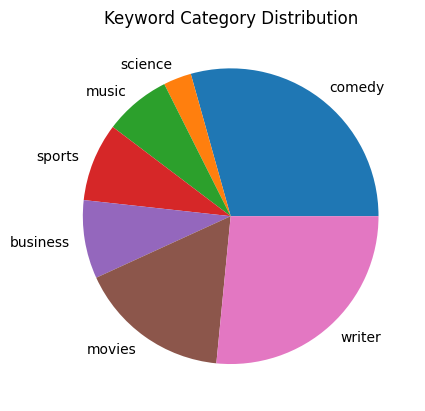

In [105]:
labels = []
sizes = []

for x, y in category_counts.items():
    labels.append(x)
    sizes.append(y)

plt.pie(sizes, labels=labels)
plt.title("Keyword Category Distribution")
plt.savefig('graphs/piechart.png', bbox_inches = 'tight')
plt.show()

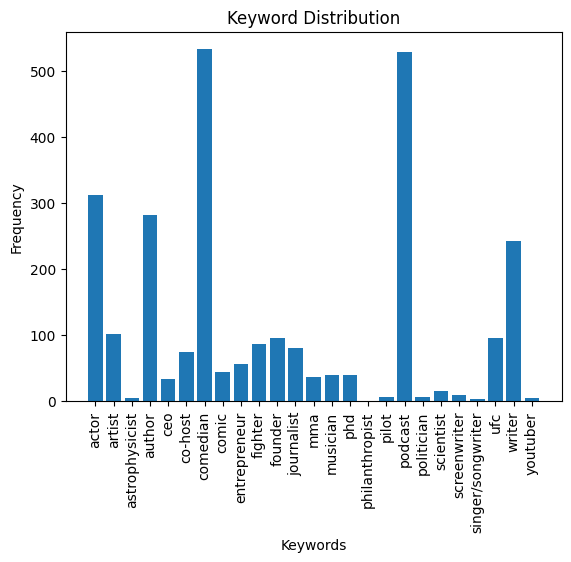

In [112]:
counts = df.groupby(['category'])['category'].count()

plt.bar(counts.index, counts)

plt.title("Keyword Distribution")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.savefig('graphs/keyword_distribution_bar.png', bbox_inches = 'tight')
plt.show()

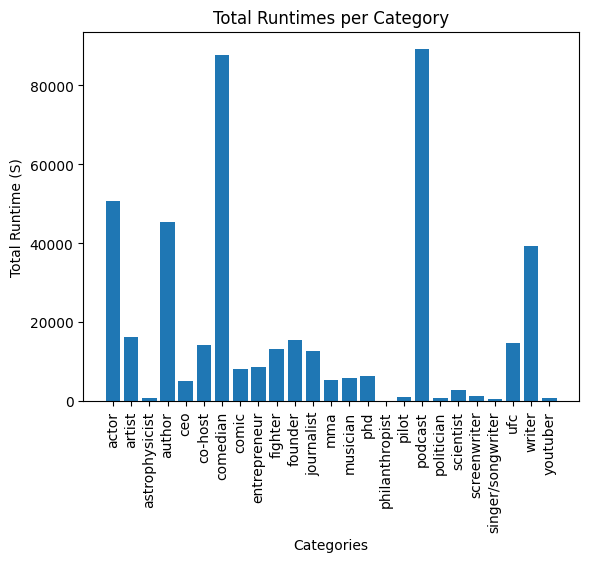

In [113]:
test = df.groupby(['category'])['duration_seconds'].sum()

plt.bar(test.index, test)

plt.title("Total Runtimes per Category")
plt.xlabel("Categories")
plt.ylabel("Total Runtime (S)")
plt.xticks(rotation=90)
plt.savefig('graphs/total_runtimes_bar.png', bbox_inches = 'tight')
plt.show()

/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_3557/3692774470.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_duration_df = category_duration_df.append(keyword_df, ignore_index=True)
/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_3557/3692774470.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_duration_df = category_duration_df.append(sub_keyword_df, ignore_index=True)
/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_3557/3692774470.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_duration_df = category_duration_df.append(keyword_df, ignore_index=True)
/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_3557/3692774470.py:30: FutureWarning: Th

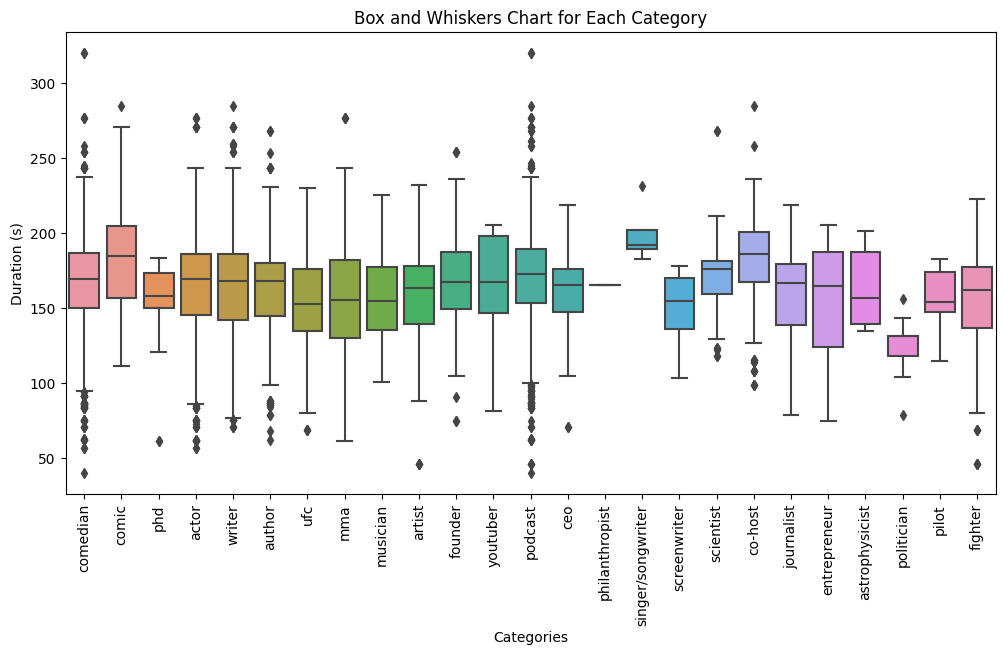

In [114]:
# Initialize new columns
for keyword in keywords:
    df[keyword] = 0
    df[f"{keyword}_sub"] = 0

# Loop through the descriptions and populate the new columns
for idx, row in df.iterrows():
    description = row["description"].lower()
    keyword_count = {}

    for keyword in keywords:
        if keyword in description:
            keyword_count[keyword] = keyword_count.get(keyword, 0) + 1
            if keyword_count[keyword] == 1:
                df.at[idx, keyword] = 1
            elif keyword_count[keyword] == 2:
                df.at[idx, f"{keyword}_sub"] = 1

# Create a new DataFrame with only categories and durations
category_duration_df = pd.DataFrame(columns=["Category", "Duration"])

for keyword in keywords:
    keyword_data = df.loc[df[keyword] == 1, "duration_seconds"]
    keyword_df = pd.DataFrame({"Category": [keyword] * len(keyword_data), "Duration": keyword_data})
    category_duration_df = category_duration_df.append(keyword_df, ignore_index=True)
    
    sub_keyword = f"{keyword}_sub"
    sub_keyword_data = df.loc[df[sub_keyword] == 1, "duration_seconds"]
    sub_keyword_df = pd.DataFrame({"Category": [sub_keyword] * len(sub_keyword_data), "Duration": sub_keyword_data})
    category_duration_df = category_duration_df.append(sub_keyword_df, ignore_index=True)

# Remove categories with no data
category_duration_df = category_duration_df[category_duration_df["Duration"] > 0]



# Create the box and whiskers chart
plt.figure(figsize=(12, 6))
sns.boxplot(x="Category", y="Duration", data=category_duration_df)
plt.title("Box and Whiskers Chart for Each Category")
plt.xlabel("Categories")
plt.ylabel("Duration (s)")
plt.xticks(rotation=90)
plt.savefig('graphs/box_and_whiskers.png', bbox_inches = 'tight')
plt.show()

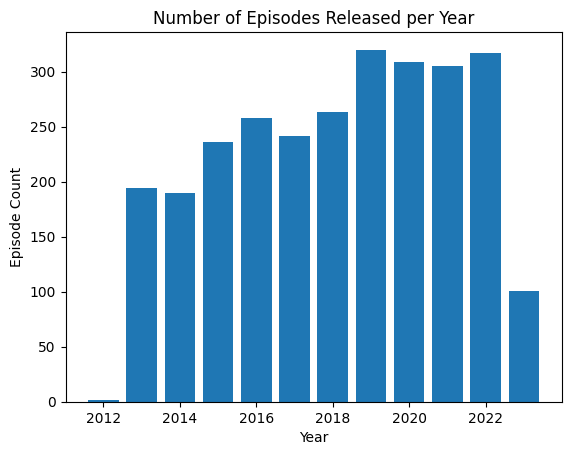

In [115]:
# Count the number of episodes per year
episodes_per_year = df['year'].value_counts().sort_index()

# Create a bar chart to visualize the episode count per year
plt.bar(episodes_per_year.index, episodes_per_year.values)
plt.title("Number of Episodes Released per Year")
plt.xlabel("Year")
plt.ylabel("Episode Count")
# Count the occurrences of each guest
guest_counts = df['guest'].value_counts()
plt.savefig('graphs/number_of_episodes_bar.png', bbox_inches = 'tight')
plt.show()

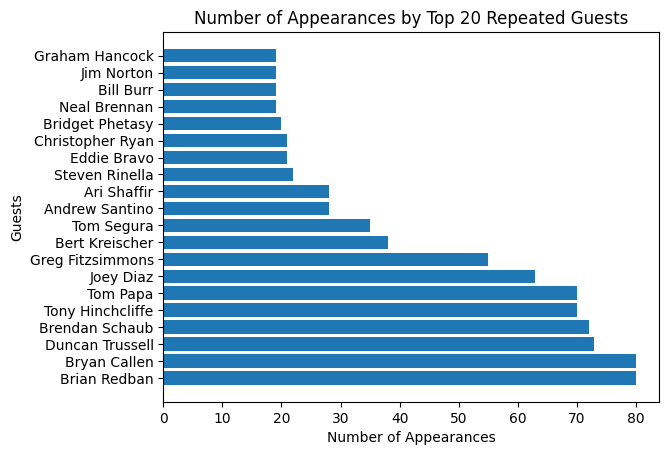

In [116]:
# Count the occurrences of each guest
guest_counts = df['guest'].value_counts()

# Filter the guest_counts for repeated guests
repeated_guest_counts = guest_counts[guest_counts > 1]

# Sort the repeated_guest_counts in descending order and select the top 20
top_20_repeated_guest_counts = repeated_guest_counts.sort_values(ascending=False).head(20)

# Create a horizontal bar chart for the top 20 repeated guests
plt.barh(top_20_repeated_guest_counts.index, top_20_repeated_guest_counts.values)
plt.title("Number of Appearances by Top 20 Repeated Guests")
plt.xlabel("Number of Appearances")
plt.ylabel("Guests")
plt.savefig('graphs/number_of_appearances_bar.png', bbox_inches = 'tight')
plt.show()

# Save and Load CSV Files

In [104]:
# Save to CSV To Reuse
df.to_csv('data_files/podcast_data.csv', index=False)

In [ ]:
# Pull Shows From CSV
df = pd.read_csv('data_files/podcast_data.csv')
df.head()